# Depresión en Reddit

## Introducción a la problemática

Actualmente hay una creciente tendencia a detectar de manera temprana problemas de salud mental en los usuarios de las redes sociales, éstas han tenido un impacto negativo en la salud mental de adolescentes y adultos jóvenes (https://www.cureus.com/articles/109723-reviewing-the-impact-of-social-media-on-the-mental-health-of-adolescents-and-young-adults), y cada vez son mas los esfuerzos que hacen las compañias detrás de las redes sociales para actuar de manera preventiva e incluso brindando apoyo. Es por ello, que el caso de uso que se abarca en este documento va justamente en relación con esta problemática. Lo que se busca con este caso de uso en particular es lograr la detección de comportamientos o tendencias a la depresión en términos de salud mental, por medio del análisis del contenido de posts de reddit. Luego con esta información sería posible realizar proyectos preventivos o incluso brindar ayuda.

Para lograr llevar a cabo este caso se uso, se hará uso del siguiente dataset:
https://www.kaggle.com/datasets/infamouscoder/depression-reddit-cleaned

Éste dataset contiene 7731 registros a la fecha y está dividido en dos columnas
* El texto (clean_text)
* La etiqueta (is_depression)

Para cada registro **el texto** es la extracción del contenido de un post de Reddit, y **la etiqueta** es su clasificación manual sobre si tiene tendendia (1) o no (0) a la depresión.
Este dataset además ya ha sido pre-procesado por lo que está relativamente limpio y podría ser usado así sin mayores cambios para entrenar un modelo de predicción, pero aún así se hará de nuevo todo el proceso de pre-procesamiento de texto con el objetivo de asegurar que los datos estén completamente listos y además porque se necesita de este proceso para preparar los datos nuevos con los que se va a poner a prueba el modelo.

Un ejemplo de cómo se ven los registros del dataset es el siguiente:

In [1]:
import pandas as pd

data = pd.read_csv("../input/depression-reddit-cleaned/depression_dataset_reddit_cleaned.csv")
data.head()

,clean_text,is_depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1


Entonces esto permite crear y entrenar un modelo de machine learning que dado el contenido de un post de reddit se pueda clasificar si tiene tendencia a la depresión o no.

El dataset no viene dividido en test, train y dev por lo que toca hacer la separación de datos manualmente.

## Problema de analítica que se desea resolver con el caso de uso.

Este tipo de problemas de clasificación de texto tienen varios problemas:
* La cantidad de variables.
* La extracción del texto para poner a prueba el modelo.
* El resultado de la predicción.
* La diversidad de métodos que existen para abordar el problema.

La cantidad de variables en un problema de clasificación de texto pueden ser tantas como la cantidad de palabras únicas del texto más largo en el dataset, por lo que se podría tener un array con decenas de miles de variables lo que haría los costos y los tiempos de entrenamiento muy altos, por lo que se deben reducir la cantidad de variables a un número considerablemente más pequeño.

La extracción del texto para poner a prueba el modelo debe ser extraido haciendo uso de técnicas de web scrapping ya que la idea es que el input de nuestra herramienta sea el link de un post de reddit, y posteriormente extraer el contenido de este.

La diversidad de métodos que existen para abordar un problema de clasificación de texto son muchos, por lo que se debe invertir tiempo en estudiar cuales de ellos dan buenos resultados y elegir uno en un tiempo razonable para lograr tener la solución lista.

## Tecnologías a utilizar en el caso de uso.

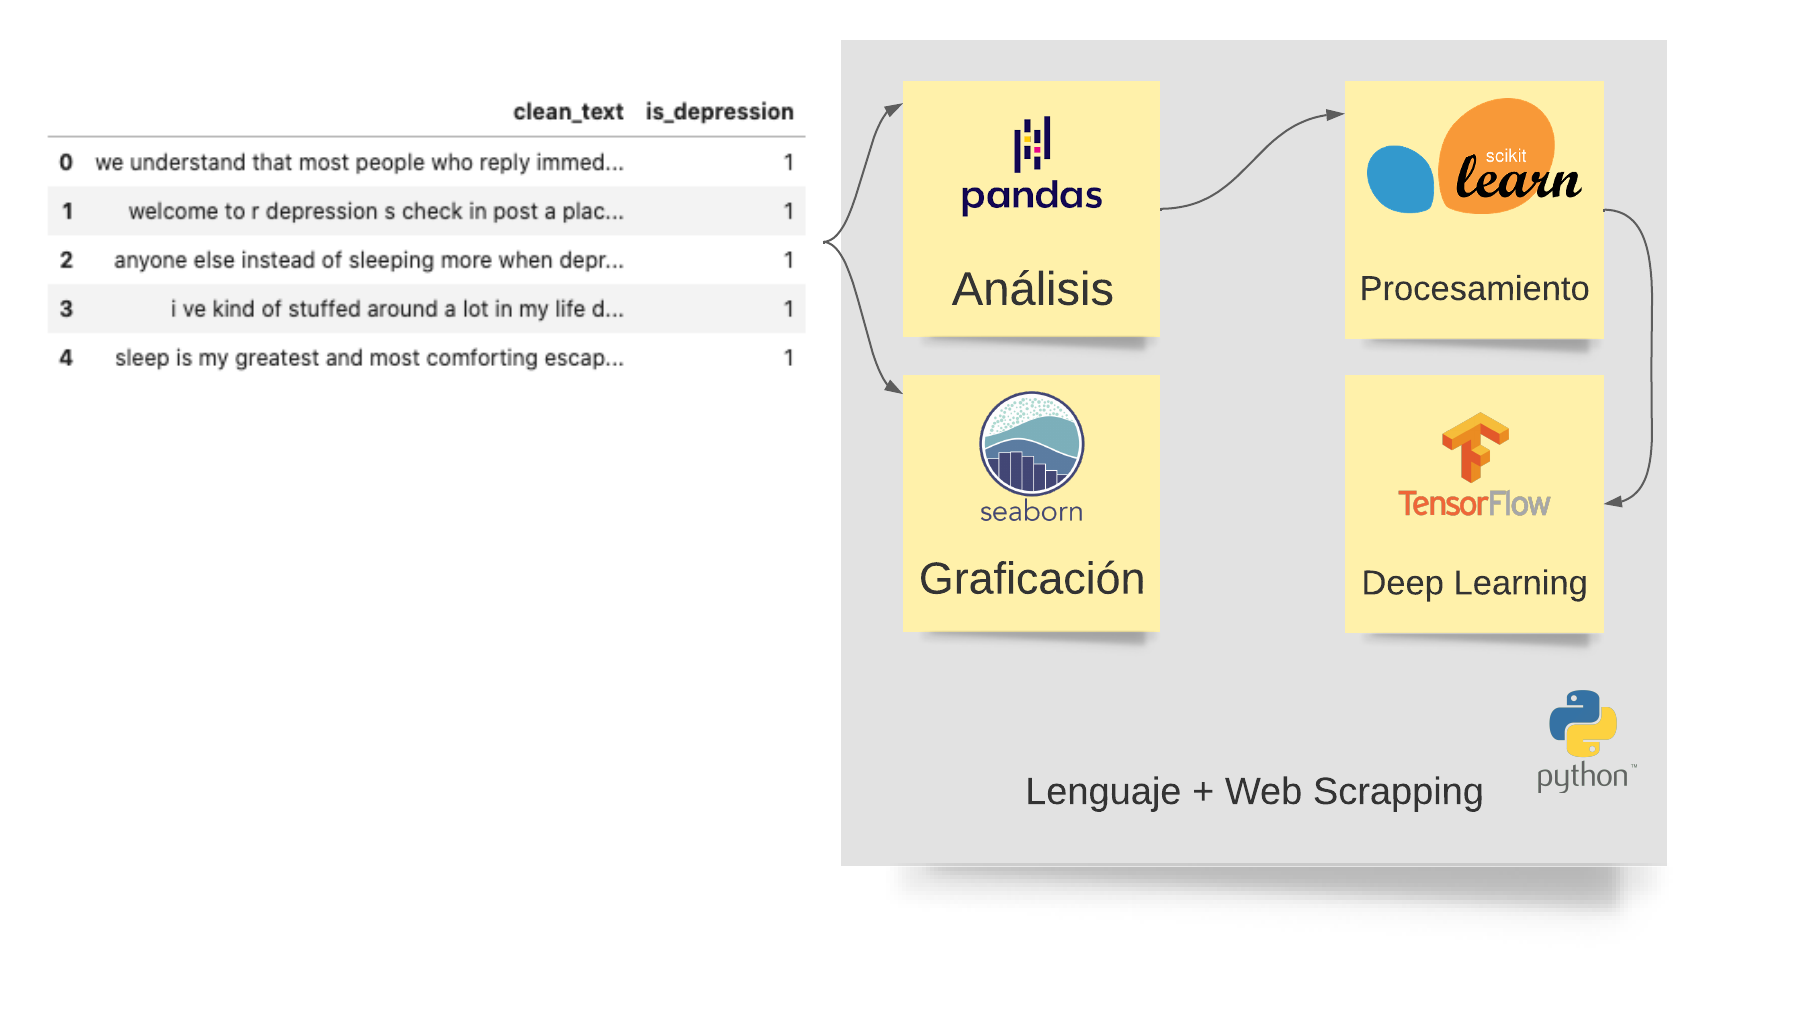

In [2]:
from IPython.display import Image
Image("../input/arquitectura/Ideation.png")

Lo primero que se hará va a ser un análisis de los datos previo a cualquier procesamiento, se estudiará el dataset y se extraerá información que pueda ser valiosa para el momento del procesamiento.

In [3]:
data.describe()

,is_depression
count,7731.000000
mean,0.495537
std,0.500012
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


Se importa la librería *seaborn* que nos permite ver los datos de manera gráfica.

<AxesSubplot:xlabel='is_depression', ylabel='count'>

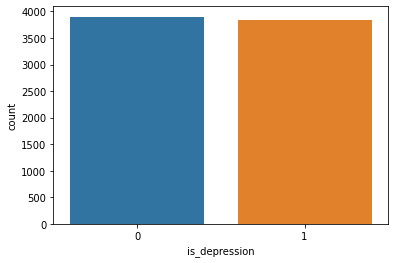

In [4]:
import seaborn as sns

# Gráfico que nos permite ver la distribución de los datos
sns.countplot(data=data, x='is_depression')

Como se puede observar, los datos están balanceados, lo que significa que hay una representación equitativa entre los posts que están catalogados con **1** y **0**

### Lematizar
Lematizar es un proceso linguístico que consiste en hallar el lema de una palabra dada en forma flexionada (plural, conjugada, etc...).
El lema es la forma que por convenio se acepta como representante de todas las formas flexionadas de una misma palabra.
https://es.wikipedia.org/wiki/Lematizaci%C3%B3n

Ejemplos de lematización:

*   Cortamos: Cortar
*   Cociendo: Cocer
*   Corre: Correr

El proceso de lematizar es ampliamente usado en sistemas de recuperación como motores de búsqueda e indexación compacta.

https://www.machinelearningplus.com/nlp/lemmatization-examples-python/

Wordnet es una base de datos léxica; es larga, gratuita, pública y disponible para el lenguaje Ingles con el objetivo de establecer relaciones semánticas estructuradas entre palabras. Ofrece herramientas de lematización y es uno de los primeros lematizadores y tamién uno de los más usados.

NLTL es una librería de Python the ofrece una interfaz a Worldnet, primero se debe descargar la báse de datos antes de usarla.

In [5]:
import nltk

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

lm = nltk.WordNetLemmatizer()

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [6]:
# Librería para trabajar con Expresiones Regulares
import re

Ahora se aplicarán ciertas transformaciones a cada uno de nuestros textos, como remover signos no alfabéticos, convertir nuestro texto en una lista de palabras en un proceso llamado Tokenización, y luego lematizar cada una de las palabras para luego unir de nuevo todo el texto ya lematizado.

In [7]:
posts = []
for post in data['clean_text']:
  # Remover todos los signos no alfabéticos
  post = re.sub("[^a-zA-Z]", " ", post)

  # Tokenizar nuestras palabras en letras.
  post = nltk.word_tokenize(post, language="english")

  # Lematizar nuestras palabras.
  post = [lm.lemmatize(word) for word in post]

  # Unir de nuevo nuestras palabras en un único string.
  post = " ".join(post)
  
  posts.append(post)

Ahora, el proceso más importante para lograr que un modelo de deep learning pueda procesar los textos es convirtiendolos en tipos de datos que las máquinas si entienden; números. Hay muchas maneras de llevar esto a cabo pero esta vez se usará un método que es quien genera uno de nuestros problemas iniciales que es la cantidad de variables, la idea es separar todas las `palabras únicas` de un post y convertirlas en columnas en un proceso llamado `Vectorización`, y luego asignar un valor a cada columna igual a la `cantidad de ocurrencias` que esa palabra tiene en el post, esto hace entonces que la cantidad de variables pase de ser una (un texto por registro) a miles (cada palabra única ahora es una variable), esto además nos lleva a tratar a las variables de manera equitativa e independiente.

Otro proceso que se hará en nuestro esfuerzo por hacer una buena reducción de dimensionalidad es la de eliminar de los posts las palabras vacías (`Stop_words`) que no aportan mucho significado a una frase o al texto en general.

Y por último lo que se hará será elegir solo las palabras de todo nuestro dataset que más se repitan, está es una cantidad muy subjetiva y la idea es ir jugando con valores para encontrar un buen equilibrio y al final tener modelo preciso. El valor elegido al final es `550`.

Esto visto de otra manera es como hacer un mapa de calor con todas las palabras de toda la base de datos y seleccionar solo el grupo en el que están concentradas la mayoría de las palabras, descartando palabras que solo se usaron una o muy pocas veces y que no nos aportan mucho contexto o información a la hora de entrenar el modelo.

Este proceso de Vectorizar y Contar se realiza fácilmente con Sklearn y su clase CountVectorizer.


In [8]:
from sklearn.feature_extraction.text import CountVectorizer

# Vectorizar, contar, remover las palabras vacías,
# y encontrar las 550 palabras más usadas.
count = CountVectorizer(stop_words = 'english', max_features = 550)

# Transformar los datos a un array
array = count.fit_transform(posts).toarray()

Se definen las características (X) y los objetivos (y)

In [9]:
X = array
y = data['is_depression'].values

Haciendo uso de `train_test_split` se separan los datos en 2 grupos;
El primer grupo de entrenamiento, y el segundo grupo de prueba, esta separación cómo se vió durante el master es comunmente 70% vs 30%, sin embargo también es una relación subjetiva y es un valor con el que se puede jugar un poco para tener un modelo bien entrenado.

También se usa el parametro `stratify=y` para decirle al método que se quiere que la porción de datos de entrenamiento tome igual representación de todos los posibles valores de `y` (0, 1)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, stratify=y
)

A partir de este punto se termina el proceso de Pre-procesamiento de datos,
Este proceso es indispensable e independiente del predictor o los métodos con los que luego se entrene el modelo, por lo que los datos tal y como los tenemos acá podrían ser enviados a una red neuronal o un clasificador de regresión logística.

Ahora se llama al módulo `GaussianNB`, proveído por Sklearn, es una interfaz al clasificador del que se habló al principio para entrenar el modelo.

In [11]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

In [12]:
# Entrenamiento del modelo
nb.fit(X_train, y_train)

GaussianNB()

In [13]:
# Se quiere saber que tan preciso es el modelo, poniendolo a prueba con los 
# datos que reservamos para validación.
nb.score(X_test, y_test)

0.9333855799373041

Cómo se ve con este método, se logró una precisión por encima del 93% que es bastante sorprendente.

Ahora se muestran los resultados del predictor usando una matriz de confusión.

La matriz de confusión muestra 


*   Verdaderos Positivos (arriba izquierda)
*   Falsos Positivos (arriba derecha)
*   Falsos Negativos (abajo izquierda)
*   Verdaderos Negativos (abajo derecha)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


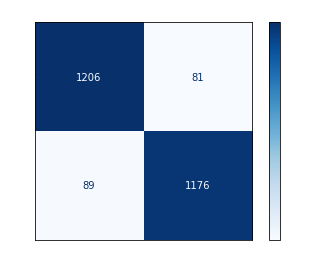

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test,nb.predict(X_test))
 
color = 'white'
matrix = plot_confusion_matrix(nb, X_test, y_test, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

In [15]:
from sklearn.metrics import classification_report
 
print(classification_report(y_test, nb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1287
           1       0.94      0.93      0.93      1265

    accuracy                           0.93      2552
   macro avg       0.93      0.93      0.93      2552
weighted avg       0.93      0.93      0.93      2552



---

#  Deep Learning with Keras

A continuación se mostrará el desarrollo de una red neuronal usando Keras con la que se espera obtener un resultado similar al obtenido usando el Clasificador de Bayes.

Se usará la misma base de datos, y el pre-procesamiento de los datos será el mismo también, por lo que se va a obviar esa parte y usar las mismas variables que se tienen ya creadas.

In [16]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the model
model = keras.Sequential([
    layers.Dense(100, activation='relu'),

    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(100, activation='relu'),

    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

2022-10-13 03:20:59.692205: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Al principio se usaron muchas más neuronas (256 por capa), y un dropput de 0.2

Pero después de varias iteraciones tuve la sensación de que la red estaba siendo muy compleja, y decidí reducir la cantidad de neuronas por capas y definir un dropout más alto, un poco jugando con los valores, y un poco obligando a la red a iterar más tratando de que buscara más relaciones ocultas entre las variables. Más adelante se ve el resultado de el tiempo invertido en la exploración de los valores en la red.

In [17]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

In [18]:
# Define EarlyStopping Callback
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
    verbose=0
)

2022-10-13 03:20:59.948789: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


<AxesSubplot:title={'center':'Accuracy'}>

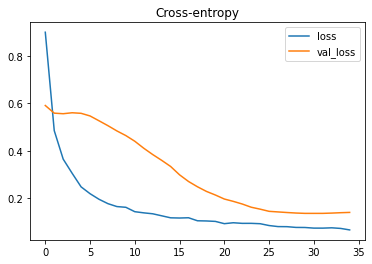

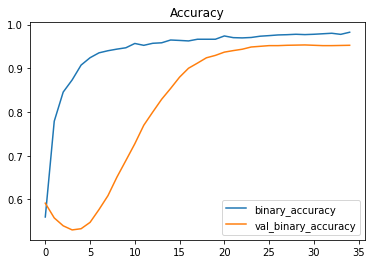

In [19]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

In [20]:
eval = model.evaluate(X_test, y_test)

80/80 [==============================] - 0s 2ms/step - loss: 0.1361 - binary_accuracy: 0.9534


Se obtuvo un resultado bastante mejor de lo esperado, y mis interpretaciones personales son que estos resultados son producto del buen pre-procesamiento de los datos.

La cantidad de epochs fueron un poco menos de 35, de 200 que se tienen cómo límite, este fue uno de los mejores resultaos que pude obtener, con otras combinaciones de capas y neuronas, la cantidad de epochs no superaba las 10 iteracioes y la red realmente no aprendía mucho y se obtenía como máximo un 0.59 de precisión.

Si lo que llevo del trabajo hasta ahora se considera como un buen avance, entonces lo que me pondré a hacer de ahora en adelante es a completar la herramienta cómo fue descrita en la primera entrega:

1.   Implementar un método que reciba por parámetro un link
2.   Validar que el link cumpla con las condiciones de ser un post de Reddit
3.   Con herramientas de Web Scrapping extraer el contenido del post
4.   Transformar los datos para que cumplan con los requerimientos de la red
5.   Usar la red para predecir el Output de la clasificación
6.   Presentar el trabajo en el formato requerido

**Idealmente se mostrará el resultado de la clasificación obtenida por los 2 modelos.**

# Implementación de Gaussian Naive Bayes con Python y Sklearn para clasificar posts de reddit entre 2 posibles resultados (1, 0) siendo 1 tendiente o con tono depresivo y 0 sin tendencia o tono depresivo.
## El teorema de Bayes
El teorema de Bayes, en la teoría de la probabilidad, es una proposición planteada por el matemático inglés Thomas Bayes y publicada póstumamente en 1763, que expresa la probabilidad condicional de un evento aleatorio `A` dado `B` en términos de la distribución de probabilidad condicional del evento `B` dado `A` y la distribución de probabilidad marginal de solo `A`.
https://es.wikipedia.org/wiki/Teorema_de_Bayes

## Gaussian Naive Bayes (Clasificador bayesiano ingenuo)
Es un modelo de clasificación probabilístico básico pero efectivo en machine learning que está basado en el teorema de Bayes.
Este método asume que las características contributyen de manera equitativa e independiente a la selección de un valor de salida o resultado.
Aunque esta característica haría el modelo inviable en circunstancias del mundo real, esta suposición produce resultados muy satisfactorios y es comunmente usado en clasificación y categorización de texto.

## Tipos de Clasificadores Bayesianos
### Gaussian Naive Bayes
Empleado cuando las características son continuas y se espera que sigan una distribución Gaussiana.

### Bernoulli Naive Bayes
Empleado cuando las características son boleanas y se espera que sigan una distribución de Bernoulli

### Miltinominal Naive Bayes
Hace uso de distribuición Muntinomial y también es usado para resolver problemas de clasificación de texto o documentos.